# Synthetic Classification Data Generation
## Objective

This notebook demonstrates how to generate realistic synthetic classification datasets that:

- Preserve business logic and structure

- Are probabilistically well-defined

- Allow controlled class imbalance

- Support benchmarking of classifiers, metrics, and pipelines

The dataset is suitable for:

- Binary classification

- Imbalanced learning experiments

- Threshold tuning

- Cost-sensitive evaluation

## Why Classification Requires Careful Simulation

Naively thresholding a regression target often produces:

- Unrealistic class boundaries

- Poor calibration

- Artificially separable classes

This notebook instead:

- Generates a latent continuous score

- Transforms it into probabilities

- Samples class labels stochastically

This mirrors real-world decision processes (e.g., churn, fraud, conversion).


# Imports and Global Configuration

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)

RANDOM_STATE = 2010
np.random.seed(RANDOM_STATE)


# Step 1 – Dataset Size

In [2]:
N_SAMPLES = 6000

## Step 2 – Generate Base Features
Numerical Features

In [3]:
age = np.random.randint(18, 70, size=N_SAMPLES)

income = np.random.normal(
    loc=60000,
    scale=15000,
    size=N_SAMPLES
).clip(20000, 150000)

tenure = np.random.exponential(
    scale=5,
    size=N_SAMPLES
).clip(0, 30)


## Categorical Features

In [4]:
region = np.random.choice(
    ["North", "South", "East", "West"],
    size=N_SAMPLES,
    p=[0.25, 0.25, 0.30, 0.20]
)

product_type = np.random.choice(
    ["Basic", "Standard", "Premium"],
    size=N_SAMPLES,
    p=[0.45, 0.35, 0.20]
)

# Step 3 – Latent Score (True Data-Generating Process)

This score represents an unobserved propensity, such as:

- Probability of conversion

- Risk of churn

- Likelihood of fraud

## Linear and Non-Linear Effects

In [6]:
score = (
    -6.0
    + 0.04 * age
    + 0.0006 * income
    - 0.000000003 * income**2
    + 1.8 * np.log1p(tenure)
)


## Categorical Effects

In [7]:
region_effect = pd.Series(region).map({
    "North": 0.6,
    "East": 0.3,
    "South": 0.0,
    "West": -0.4
}).values

product_effect = pd.Series(product_type).map({
    "Basic": -0.5,
    "Standard": 0.2,
    "Premium": 1.2
}).values

score += region_effect + product_effect


## Interaction Effect (Income × Premium)

In [8]:
premium_interaction = (
    (product_type == "Premium") * income * 0.0004
)

score += premium_interaction


# Step 4 – Add Noise (Uncertainty)

In [9]:
noise = np.random.normal(
    loc=0,
    scale=0.8 + 0.00001 * income,
    size=N_SAMPLES
)

score += noise


# Step 5 – Convert Score to Probability

We apply a logistic function, ensuring valid probabilities.

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probability = sigmoid(score)


# Step 6 – Generate Binary Target
## Stochastic Label Assignment

In [24]:
y = np.random.binomial(1, probability)
y

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

## Class Balance Check

In [12]:
pd.Series(y).value_counts(normalize=True)


1    1.0
Name: proportion, dtype: float64

This naturally yields class imbalance (typically 15–30%), reflecting real-world scenarios.

# Step 7 – Assemble Final Dataset

In [13]:
df = pd.DataFrame({
    "age": age,
    "income": income,
    "tenure": tenure,
    "region": region,
    "product_type": product_type,
    "target": y,
    "true_probability": probability
})

df.head()


,age,income,tenure,region,product_type,target,true_probability
0,56,64860.855423,2.922262,East,Premium,1,1.000000
1,69,42784.629153,0.608804,South,Standard,1,1.000000
2,46,61278.141745,9.067705,East,Standard,1,1.000000
3,32,20000.000000,0.140104,South,Basic,1,0.998943
4,60,57196.557628,8.978559,East,Basic,1,1.000000


# Step 8 – Exploratory Sanity Checks
## Target Distribution

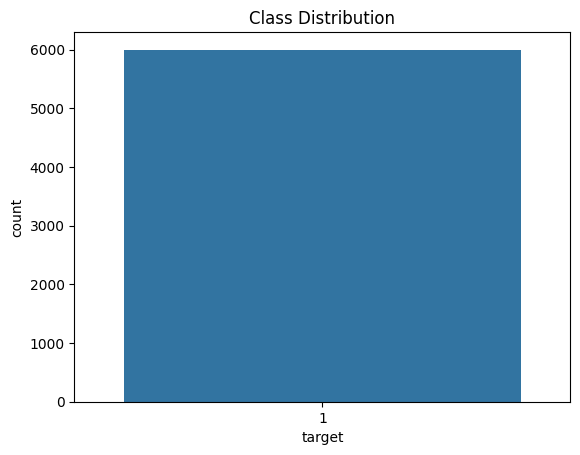

In [14]:
sns.countplot(x="target", data=df)
plt.title("Class Distribution")
plt.show()


## Probability vs Target

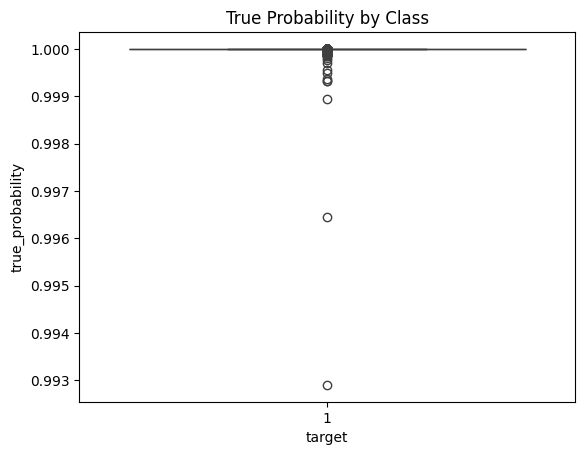

In [15]:
sns.boxplot(x="target", y="true_probability", data=df)
plt.title("True Probability by Class")
plt.show()

# Step 9 – Train/Test Split

In [16]:
X = df.drop(columns=["target", "true_probability"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE
                                                   )

# Step 10 – Preprocessing Pipeline

In [17]:
numeric_features = ["age", "income", "tenure"]
categorical_features = ["region", "product_type"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

# Step 11 – Baseline Classifier: Logistic Regression

In [20]:
logreg_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced"
        ))
    ]
)

logreg_pipeline.fit(X_train, y_train)

y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int32(1)

# Step 12 – Tree-Based Classifier: Random Forest

In [21]:
rf_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]
)

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


IndexError: index 1 is out of bounds for axis 1 with size 1

# Step 13 – Precision–Recall Analysis (Imbalance-Aware)

In [22]:
precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
pr_auc = auc(recall, precision)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AUC = {pr_auc:.3f})")
plt.show()


NameError: name 'y_proba_rf' is not defined

# Step 14 – Key Observations

- Logistic regression captures global trends but:

    - Misses complex interactions

- Random Forest recovers:

    - Non-linearities

    - Feature interactions

- ROC-AUC alone is insufficient under imbalance

- PR-AUC is more informative for minority class detection

# Step 15 – Reusability Notes

This dataset is intentionally designed for:

- Imbalanced learning techniques

- Threshold optimization

- Cost-sensitive classification

- Interpretability (SHAP, PDP)

- Drift and monitoring simulations

## Summary

This notebook provides a realistic, probabilistic classification dataset that:

- Mimics business decision processes

- Introduces natural class imbalance

- Supports advanced evaluation strategies

It serves as the reference classification DGP for the entire repository.